## 2.10 Tensorflow Datasets
In order to use a Dataset we need three steps:
1. **Importing Data** : Create a Dataset instance from some data  
2. **Create an Iterator** : By using the created dataset to make an Iterator instance to iterate thought the dataset
3. **Consuming Data** : By using the created iterator we can get the elements from the dataset to feed the model  

#### Generating data from numpy
This is the common case, we have a numpy array and we want to pass it to tensorflow.

In [1]:
import tensorflow as tf;
import numpy as np
# create a random vector of shape (100,2)
x = np.random.sample((100,2))
# make a dataset from a numpy array
dataset = tf.data.Dataset.from_tensor_slices(x)

In [5]:
data_iter = dataset.make_one_shot_iterator()
dt = data_iter.get_next()

In [11]:
sess =tf.Session()
with sess.as_default():
    print (sess.run(dt))
    print (sess.run(dt))
    

[0.8775927  0.50346294]
[0.35036019 0.01597385]


In [12]:
with sess.as_default():
    print (sess.run(dt))
    print (sess.run(dt))
    

[0.21268736 0.93003424]
[0.4789219  0.63771947]


## Create tensorflow Dataset from Placeholders
This is useful when we want to dynamic change the data inside the Dataset, we will se later how.

In [5]:
x = tf.placeholder(tf.float32, shape=[None,2])
dataset = tf.data.Dataset.from_tensor_slices(x)

## Creating tensorflow Dataset from Python Generators

In [6]:
# from generator
sequence = np.array([[[1]],[[2],[3]],[[3],[4],[5]]])
def generator():
    for el in sequence:
        yield el
dataset = tf.data.Dataset().batch(1).from_generator(generator,
                                           output_types= tf.int64, 
                                           output_shapes=(tf.TensorShape([None, 1])))
iter = dataset.make_initializable_iterator()
el = iter.get_next()
with tf.Session() as sess:
    sess.run(iter.initializer)
    print(sess.run(el))
    print(sess.run(el))
    print(sess.run(el))

[[1]]
[[2]
 [3]]
[[3]
 [4]
 [5]]


## Using Keras for Data Augmentation

In [20]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('img/dog.jpeg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `img/preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='img/preview', save_prefix='dog', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

21


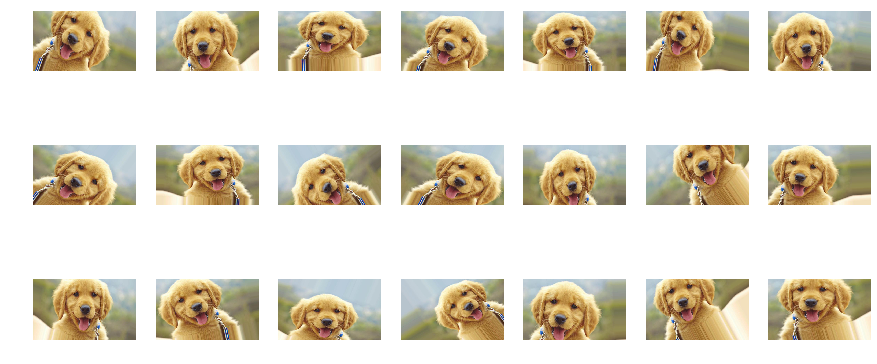

In [35]:
import matplotlib.pyplot as plt;
from PIL import Image;
import os;
fig,ax = plt.subplots(nrows=3,ncols=7,figsize=(15,7))
indices = [(i,j) for i in range(3) for j in range(7)]
filenames = [filename for filename in os.listdir('img/preview') if filename.startswith('dog_')]
for i in range(21):
    image = Image.open('img/preview/'+filenames[i]);
    ax[indices[i][0],indices[i][1]].imshow(image)
    ax[indices[i][0],indices[i][1]].axis('off')

print (len(filenames))

## Using Keras for Data Augmentation via Directory
The DataIter is generated based on the Preprocessing Generator input and the directory location. The class mode can be 'binary'(for 2 classes) or 'categorical' (for multiple classes). The label is returned as a One hot vector. 

In [42]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

dataiter = datagen.flow_from_directory(
        'img/catsvsdogs',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')
i = 0
for batch in dataiter:
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
        
    

Found 6 images belonging to 2 classes.


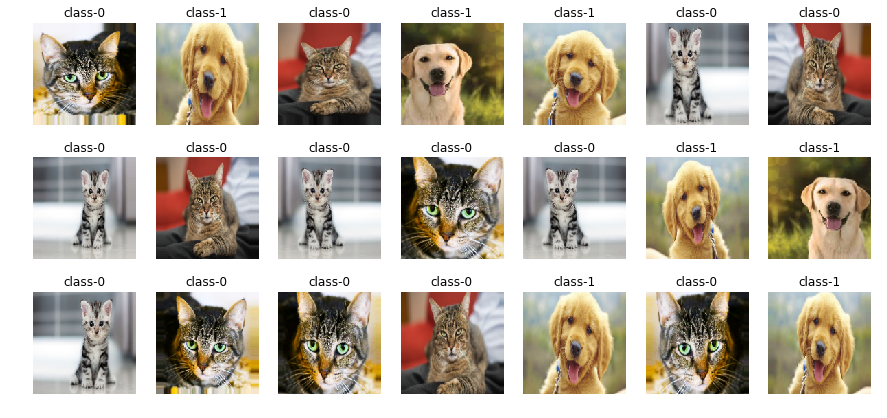

In [50]:
i = 0
fig,ax = plt.subplots(nrows=3,ncols=7,figsize=(15,7))

for batch in dataiter:
    ax[indices[i][0],indices[i][1]].imshow(np.array(batch[0][0],dtype=np.uint8))
    ax[indices[i][0],indices[i][1]].axis('off')
    ax[indices[i][0],indices[i][1]].set_title('class-'+str(np.argmax(batch[1])))
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely


## Using custom-generator

In [1]:
import pandas as pd;

In [68]:
dclist = pd.read_csv('dclist.csv')
dclist.head()

,location,class
0,cats/cat1.jpg,0
1,cats/cat2.jpg,0
2,cats/cat3.jpg,0
3,dogs/dog1.jpeg,1
4,dogs/dog2.jpeg,1


In [69]:
import numpy as np;
prefix = 'img/catsvsdogs'
def name_gen():
    for elem in dclist.to_dict('records'):
        path = prefix + '/'+elem['location']
        label = np.zeros((2,))
        label[elem['class']]=1;
        yield np.array(Image.open(path).resize((227,227))),label;

In [70]:
for elem in name_gen():
    print (elem[0].shape,elem[1].shape)

(227, 227, 3) (2,)
(227, 227, 3) (2,)
(227, 227, 3) (2,)
(227, 227, 3) (2,)
(227, 227, 3) (2,)
(227, 227, 3) (2,)


In [62]:
import tensorflow as tf;

In [71]:
ds = tf.data.Dataset.from_generator(name_gen,
                                    output_types=(tf.float64,tf.float64),
                                    output_shapes=((227,227,3),(2,) ))
                                 

In [80]:
element = ds.repeat(10).shuffle(1000).batch(3).make_one_shot_iterator().get_next()
with tf.Session() as sess:
    try:
        while(True):
            _dt,_label = sess.run(element)
            print (_dt.shape,_label.shape)
    except:
        print ('program ended')
        
    

(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
(3, 227, 227, 3) (3, 2)
program ended
